In [11]:
import qimax.utilities
import qimax.tensor
import qimax.gate
import qimax.converter
import numpy as np, qiskit, re

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


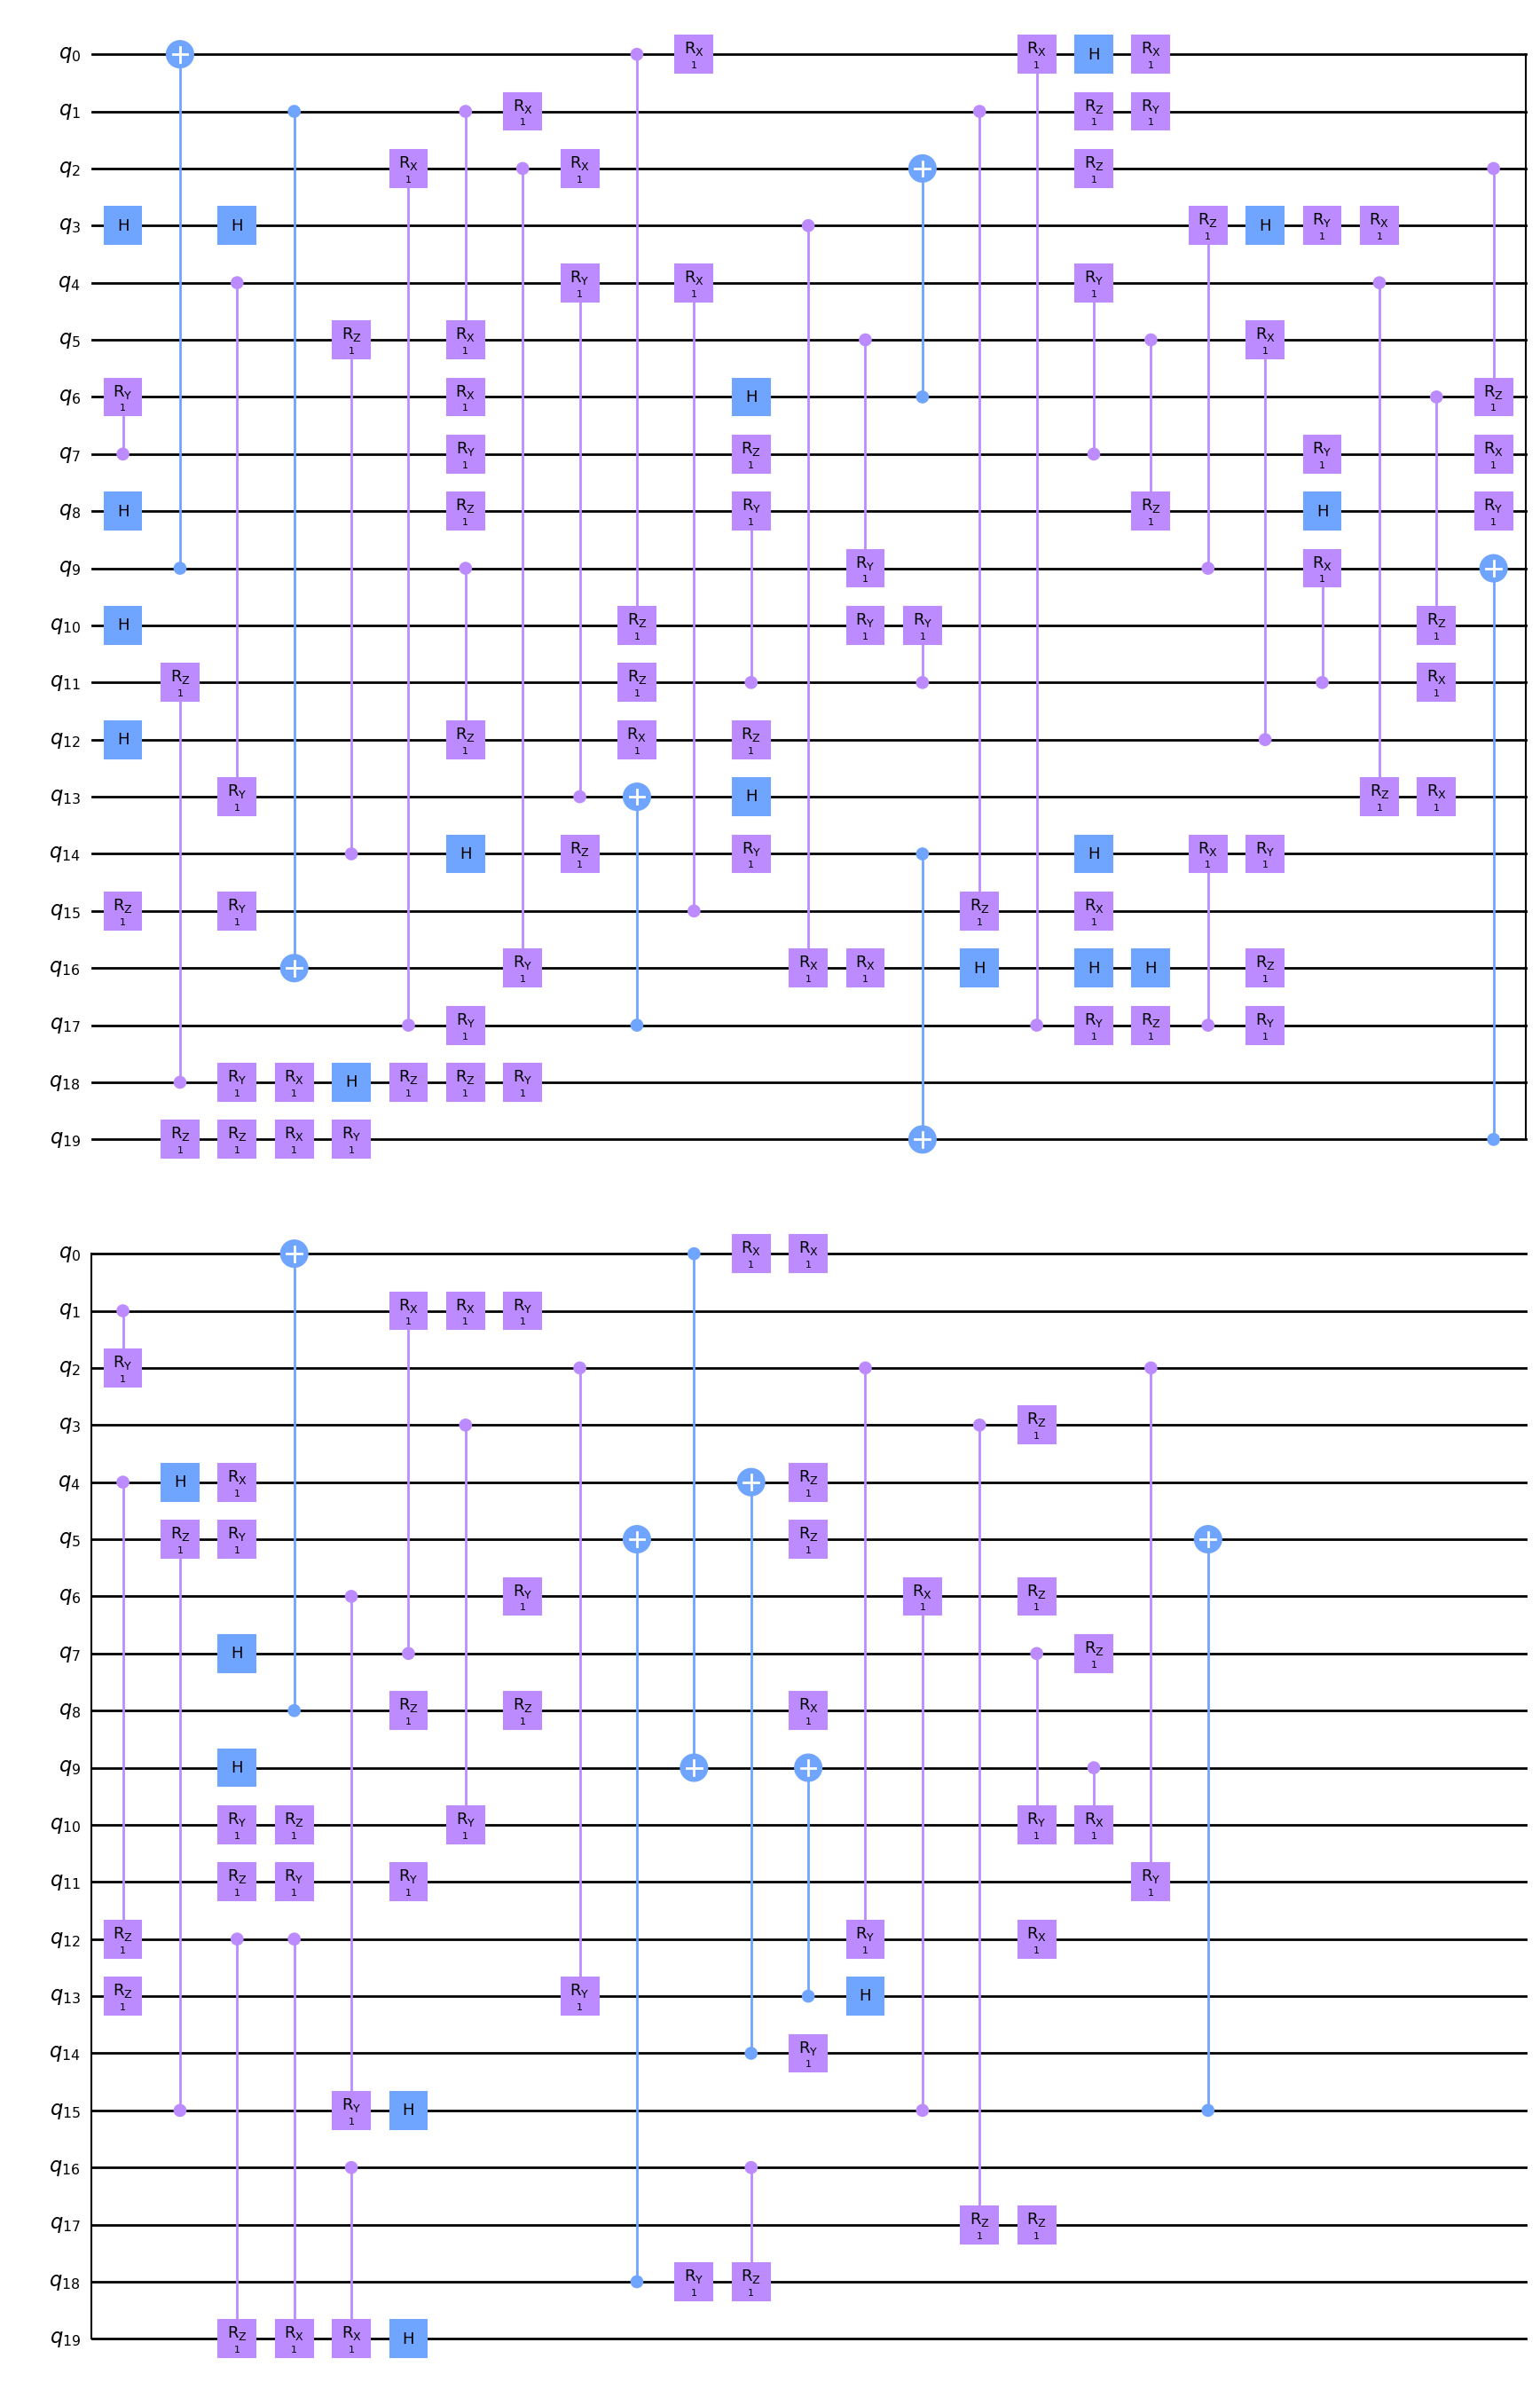

In [12]:
import qiskit.quantum_info as qi
import qimax.constant
from qoop.core.random_circuit import generate_with_pool
from qoop.core.gradient import grad_loss
%load_ext autoreload
%autoreload 2
num_qubits = 20
qc = generate_with_pool(num_qubits, 10)
qc = qc.assign_parameters([1] * qc.num_parameters)
qc.draw('mpl')
# grad_loss1 = grad_loss(qc, [1] * qc.num_parameters)
# print(grad_loss1)

In [47]:
qi.Statevector.from_instruction(qc).data

array([-3.57618320e-04-3.36729584e-05j, -9.46629890e-05-2.24740299e-04j,
       -1.44052202e-03-1.47829753e-03j, ...,
        9.56679909e-06-5.68084490e-06j, -1.25411428e-06+2.69985865e-06j,
        2.33546424e-06+7.16862661e-06j])

In [48]:
qi.Statevector.from_instruction(qc_basis).data

array([-3.57618320e-04-3.36729584e-05j, -9.46629890e-05-2.24740299e-04j,
       -1.44052202e-03-1.47829753e-03j, ...,
        9.56679909e-06-5.68084490e-06j, -1.25411428e-06+2.69985865e-06j,
        2.33546424e-06+7.16862661e-06j])

In [50]:
qc.count_ops()

OrderedDict([('ry', 23),
             ('crx', 21),
             ('h', 21),
             ('rz', 17),
             ('cx', 17),
             ('crz', 13),
             ('rx', 13),
             ('cry', 12)])

In [49]:
qc_basis.count_ops()

OrderedDict([('crx', 21),
             ('ry', 19),
             ('rz', 18),
             ('cx', 17),
             ('crz', 13),
             ('cry', 12),
             ('rx', 11),
             ('h', 11)])

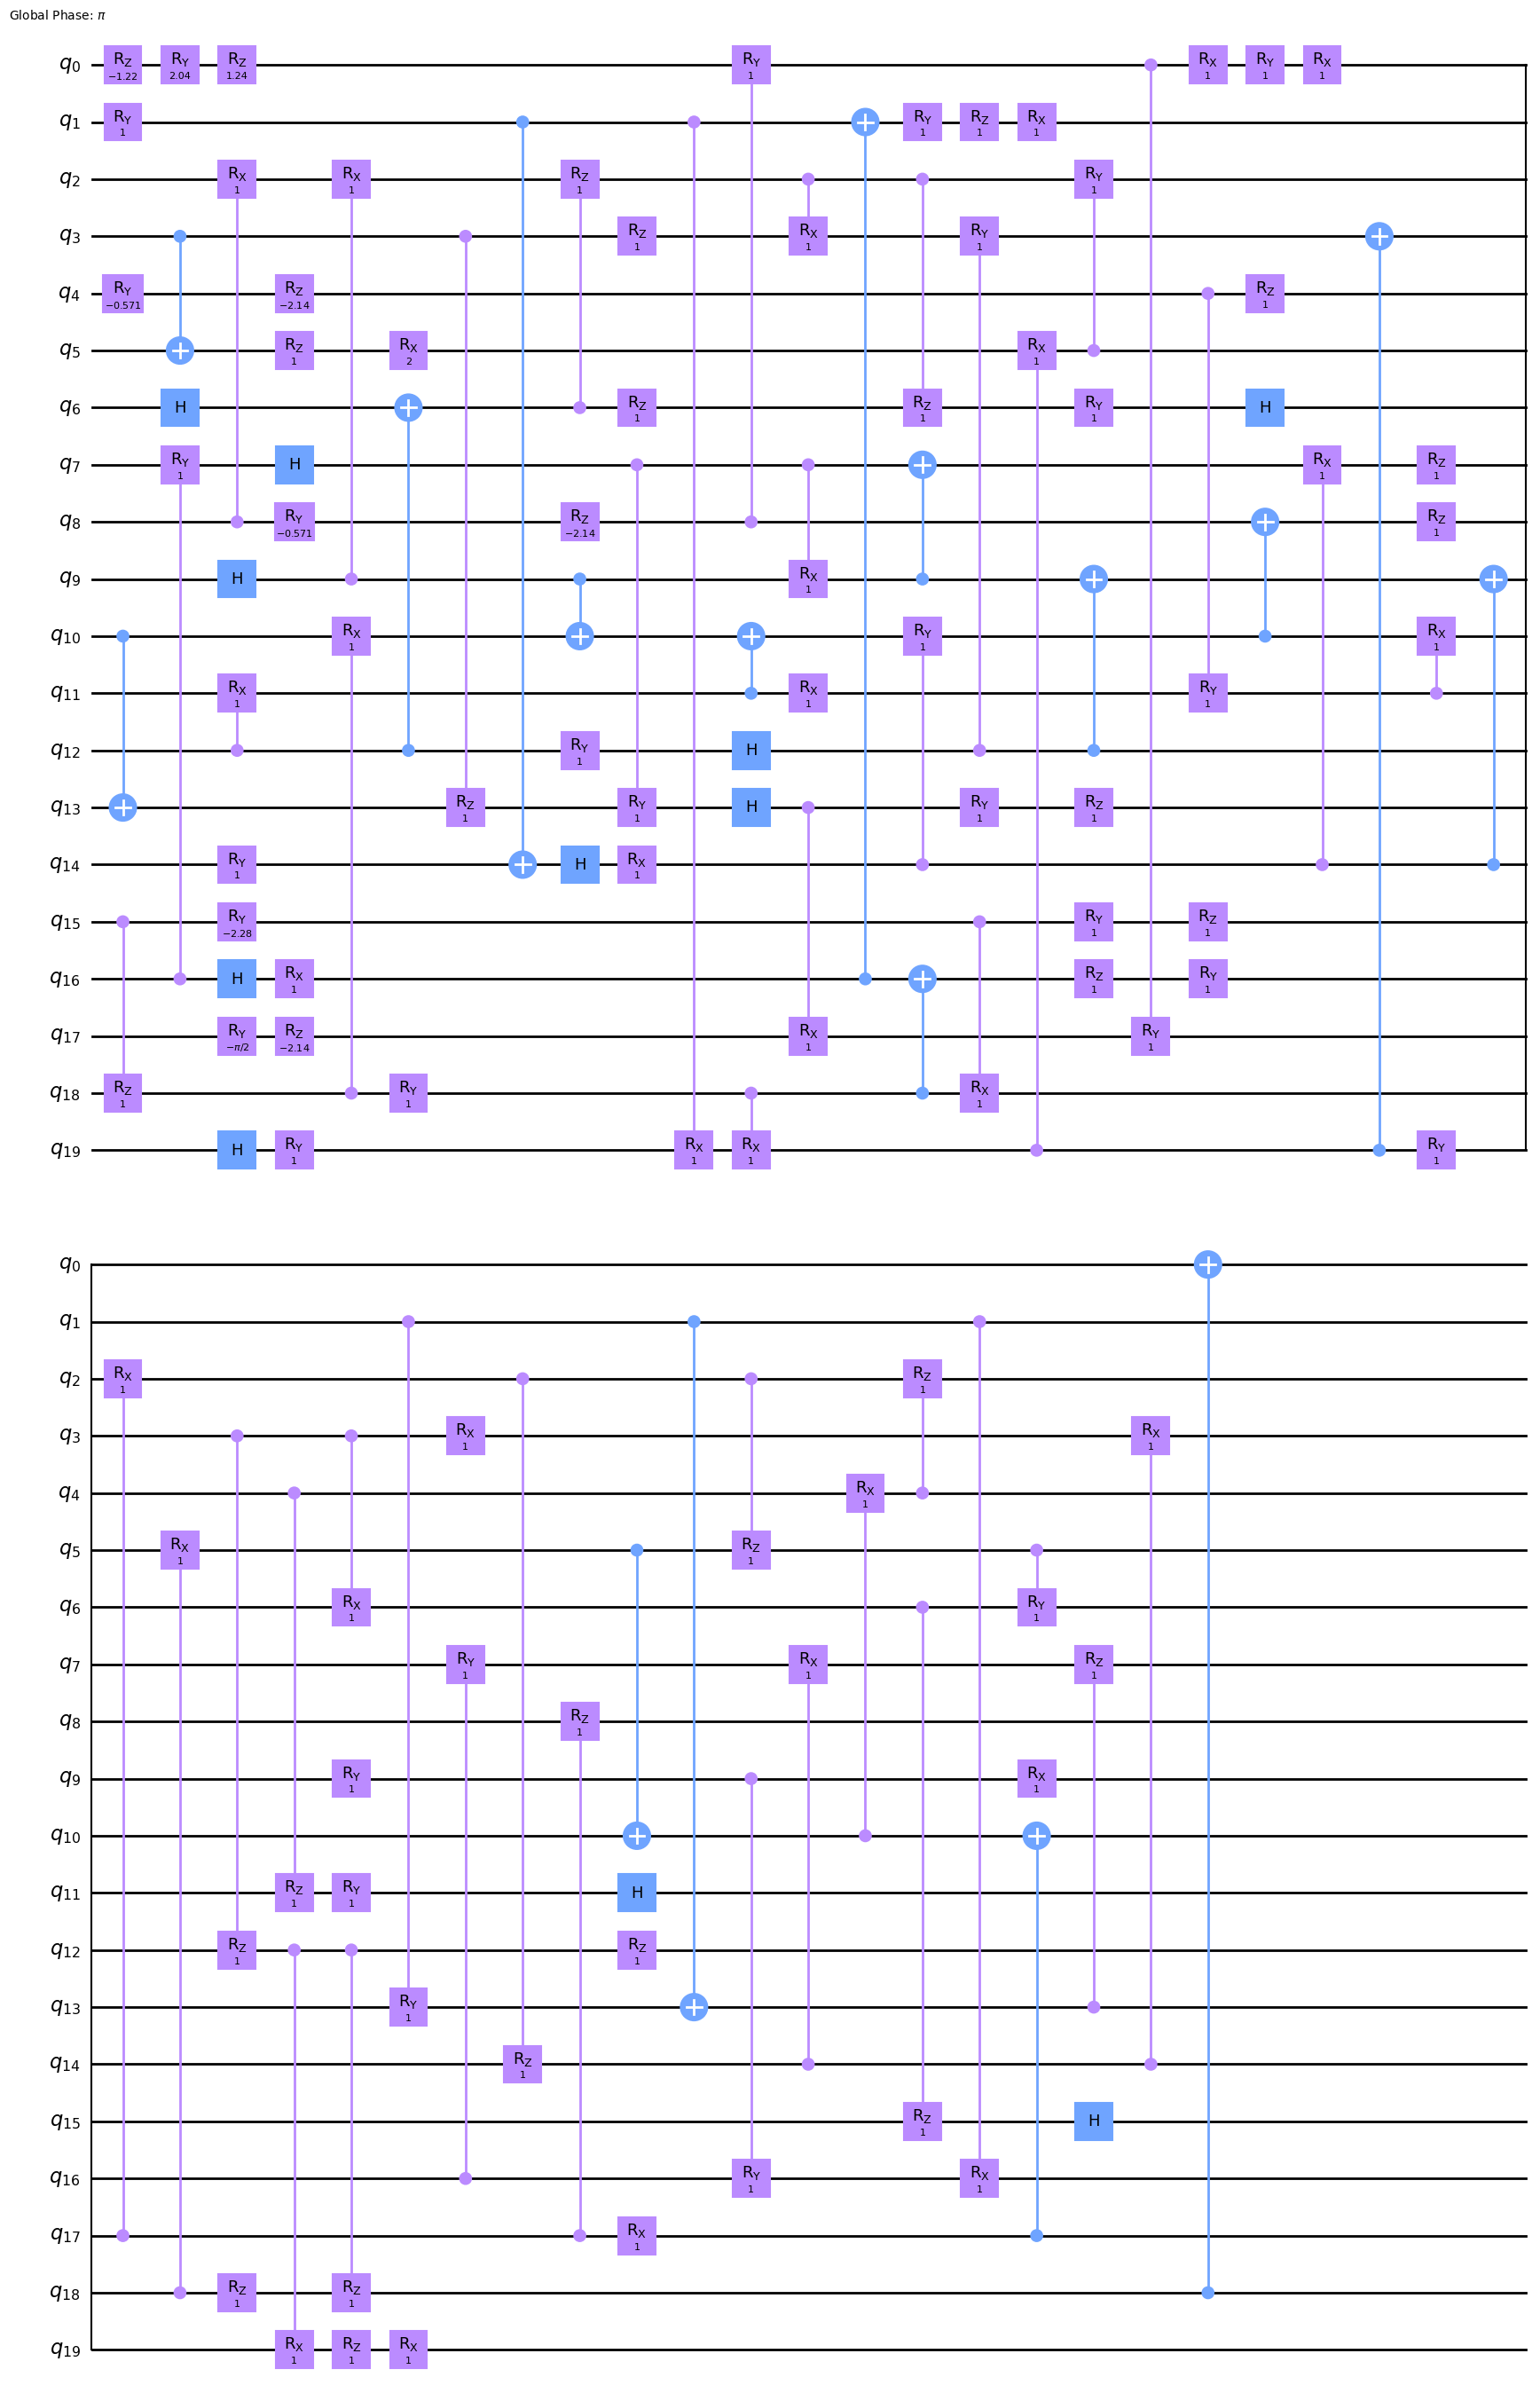

In [46]:
from qiskit.providers.basicaer import QasmSimulatorPy
backend = QasmSimulatorPy()
qc_basis = qiskit.transpile(qc, backend, optimization_level = 1,
    basis_gates=['h', 'cx',
                'rx','ry','rz',
                'crx','cry','crz'])
qc_basis.draw('mpl')

In [13]:
state = qi.Statevector.from_instruction(qc)
state.data

array([ 0.04937702-0.01275364j, -0.01264229+0.01608522j,
       -0.0015097 +0.00921762j, ...,  0.00619189-0.00485945j,
        0.01566362-0.01938955j,  0.00757447+0.03837875j])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


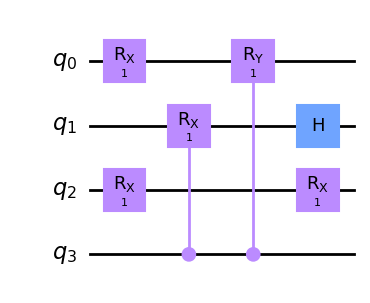

In [38]:
num_qubits = 4
qc = generate_with_pool(num_qubits, 2)
qc = qc.assign_parameters([1] * qc.num_parameters)
qc.draw('mpl')

In [66]:
import qimax.constant
import qimax.converter
import qimax.splitter
import qimax.circuit
matrices = []
Us = []
Usm = [] # [U_{0:m-1}, U_{1:m-1}, ... U_{m-1:m-1}]
index = 0
qasm_gates = qimax.converter.qasm_to_qasmgates(qc.qasm())
qcs = qimax.splitter.qasmgates_to_qcs2(qasm_gates)
#qcs.reverse() 
for qasmgates in qcs:
    gates = qimax.converter.qasmgates_to_gates(qasmgates)
    params_form, tensor_form = qimax.converter.gates_to_string(gates, num_qubits)
    u = qimax.circuit.U(params_form, tensor_form, index)
    if u.compare(Us) == False:
        index += 1
        u.to_matrix()
    Us.append(u)
Uk = np.eye(2**num_qubits)
for u in Us[1:]:
    Uk = u.matrix_form @ Uk
    Usm.append(Uk)
Usm.reverse() # Now is [U_{1:m-1}, ... U_{m-1:m-1}] # ignore U_{0:m-1}, m = 5, [U_{1:4}, U_{2:4}, U_{3:4}, U_{4:4]

Uresult = []
Ufront = np.eye(2**num_qubits)
i = 0
while i < len(Usm):
    Uleft = Ufront @ Us[i].plus_params_form(qimax.constant.epsilon).to_matrix() @ Usm[i]
    Uright = Ufront @ Us[i].plus_params_form(-qimax.constant.epsilon).to_matrix() @ Usm[i]
    Uresult.append(Uleft)
    Uresult.append(Uright)
    Ufront = Us[i].to_matrix() @ Ufront
    i += 1




(16, 16)
[1.0, -999, -999, -999]
(16, 16)
(16, 16)
[-999, -999, 1.0, -999]
(16, 16)
(16, 16)
[-999, 1.0, -999, -999]
(16, 16)
(16, 16)
[1.0, -999, -999, -999]
(16, 16)


In [65]:
(Uresult[0])

array([[ 0.33528165+0.j        ,  0.        +0.j        ,
         0.        -0.52217026j,  0.        +0.j        ,
         0.33528165+0.j        ,  0.        +0.j        ,
         0.        -0.52217026j,  0.        +0.j        ,
         0.        -0.1831652j ,  0.        +0.j        ,
        -0.28526292+0.j        ,  0.        +0.j        ,
         0.        -0.1831652j ,  0.        +0.j        ,
        -0.28526292+0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.36517475-0.10898509j,
         0.        +0.j        , -0.16973424-0.56872602j,
         0.        +0.j        , -0.05953883-0.19949588j,
         0.        +0.j        , -0.31069645+0.09272624j,
         0.        +0.j        , -0.19949588-0.19949588j,
         0.        +0.j        , -0.31069644+0.31069644j,
         0.        +0.j        , -0.1089851 +0.1089851j ,
         0.        +0.j        ,  0.16973425+0.16973425j],
       [ 0.        -0.52217026j,  0.        +0.j        ,
         0.3

In [51]:
qcs

[[('RX', 1.0, [0])],
 [('RX', 1.0, [2])],
 [('RX', 1.0, [3, 1])],
 [('RY', 1.0, [3, 0]), ('H', -999, [1])],
 [('RX', 1.0, [2])]]

In [6]:
result = matrices[0]
for i in range(1, len(matrices)):
    # print(matrices[i].shape)
    result = result @ matrices[i]
# return result
# matrix = qimax(qc)
test_state = result @ qimax.constant.state0(num_qubits)

IndexError: list index out of range

In [ ]:
k1 = np.kron(np.kron(gate.gate['RX'](1), gate.gate['H']), gate.gate['RX'](1))
k2 = np.kron(np.kron(constant.P(0), gate.gate['RY'](1)), gate.gate['I']) + np.kron(np.kron(constant.P(3), gate.gate['RY'](1)), gate.gate['RX'](1))
print(k2 @ (k1 @ constant.state0(3)))

[ 0.21682799+0.j          0.        -0.11845367j  0.73899825+0.j
  0.        -0.40371659j  0.        -0.07292851j -0.11357943+0.j
  0.        -0.24855667j -0.38710408+0.j        ]


In [ ]:
matrices[1] @ (matrices[0] @ constant.state0(3))

array([ 0.21682799+0.j        ,  0.        -0.11845367j,
        0.73899825+0.j        ,  0.        -0.40371659j,
        0.        -0.10395288j, -0.05678972+0.j        ,
        0.        -0.35429464j, -0.19355204+0.j        ])

In [ ]:
true_state

array([ 0.21682799+0.j        ,  0.        -0.07292851j,
        0.73899825+0.j        ,  0.        -0.24855667j,
        0.        -0.11845367j, -0.11357943+0.j        ,
        0.        -0.40371659j, -0.38710408+0.j        ])